In [11]:
import os.path
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from pathlib import Path
from tqdm import tqdm
from time import perf_counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from IPython.display import Markdown, display

In [41]:
# 데이터 경로
base_dir = Path(r'C:\Users\ysm\Desktop\dataset')
brands = ['coca', 'fanta', 'pepsi', 'pocari', 'sprite']  # 브랜드 목록

# 각 브랜드별 이미지 파일 경로 수집
filepaths = []
labels = []

for brand in brands:
    brand_dir = base_dir / brand  # 각 브랜드의 폴더 경로
    brand_images = list(brand_dir.glob(r'*.jpg'))  # JPG 이미지만 수집
    filepaths.extend(brand_images)
    labels.extend([brand] * len(brand_images))  # 브랜드 이름으로 라벨 지정

# 데이터프레임 생성
df = pd.DataFrame({
    'Filepath': [str(fp) for fp in filepaths],
    'Label': labels
})

# 음료수 별 이미지 수 최소값 찾기 
min_count = df['Label'].value_counts().min()

# 그 수를 기준으로 샘플링
can_df = pd.concat([
    df[df['Label'] == brand].sample(min_count, random_state=0)
    for brand in brands
])
can_df = can_df.sample(frac=1, random_state=0).reset_index(drop=True)

# 라벨링 확인
print(can_df)

                                            Filepath   Label
0     C:\Users\ysm\Desktop\dataset\sprite\spri97.jpg  sprite
1      C:\Users\ysm\Desktop\dataset\pepsi\peps87.jpg   pepsi
2      C:\Users\ysm\Desktop\dataset\coca\coca186.jpg    coca
3    C:\Users\ysm\Desktop\dataset\sprite\spri104.jpg  sprite
4       C:\Users\ysm\Desktop\dataset\coca\coca38.jpg    coca
..                                               ...     ...
665    C:\Users\ysm\Desktop\dataset\coca\coca160.jpg    coca
666   C:\Users\ysm\Desktop\dataset\pepsi\peps166.jpg   pepsi
667    C:\Users\ysm\Desktop\dataset\fanta\fant62.jpg   fanta
668   C:\Users\ysm\Desktop\dataset\sprite\spri16.jpg  sprite
669   C:\Users\ysm\Desktop\dataset\sprite\spri81.jpg  sprite

[670 rows x 2 columns]


In [42]:
print(f'Number of pictures: {can_df.shape[0]}\n')
print(f'Number of different labels: {len(can_df.Label.unique())}\n')
print(f'Labels: {can_df.Label.unique()}')

Number of pictures: 670

Number of different labels: 5

Labels: ['sprite' 'pepsi' 'coca' 'fanta' 'pocari']


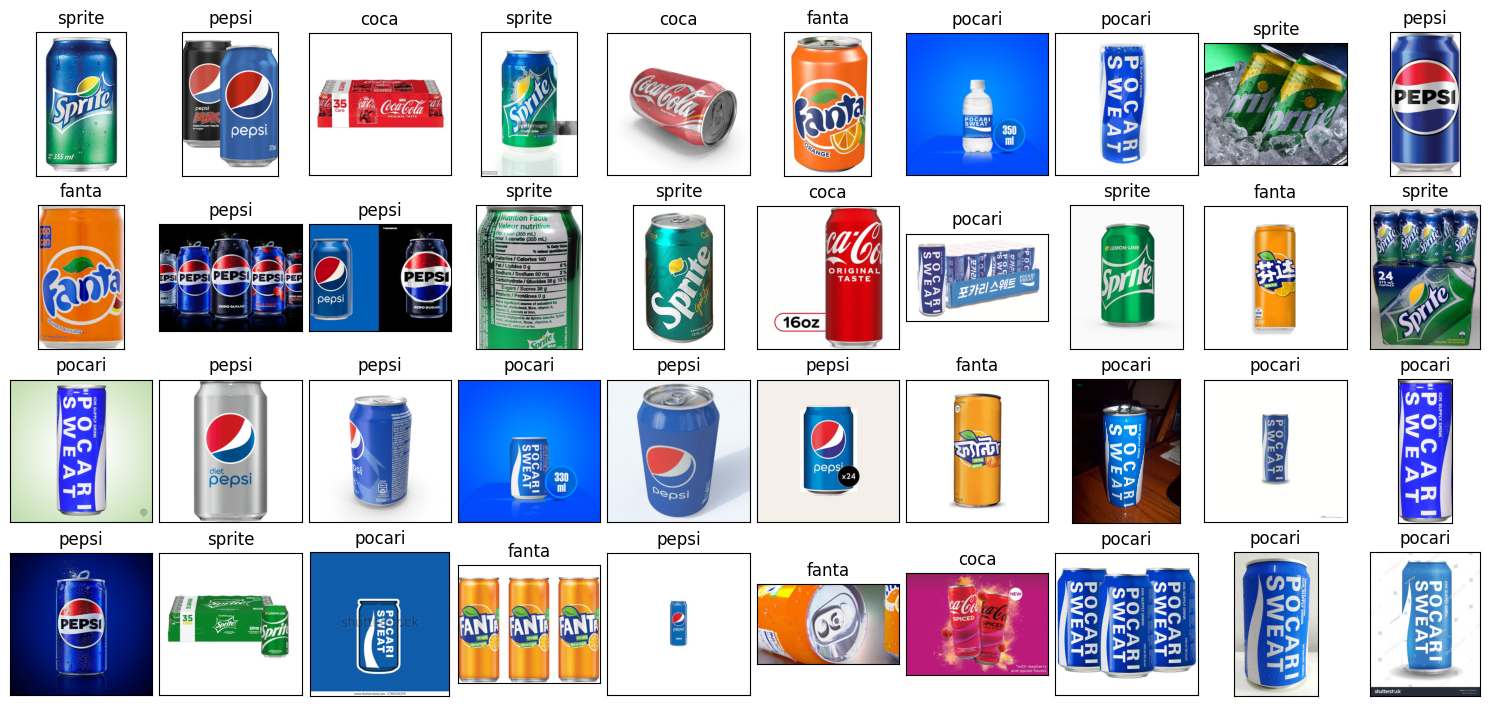

In [43]:
# 데이터 확인
fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(can_df.Filepath[i]))
    ax.set_title(can_df.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

C:\Users\ysm\AppData\Local\Temp\ipykernel_16280\1626255598.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = vc.index, y = vc, palette = "rocket")


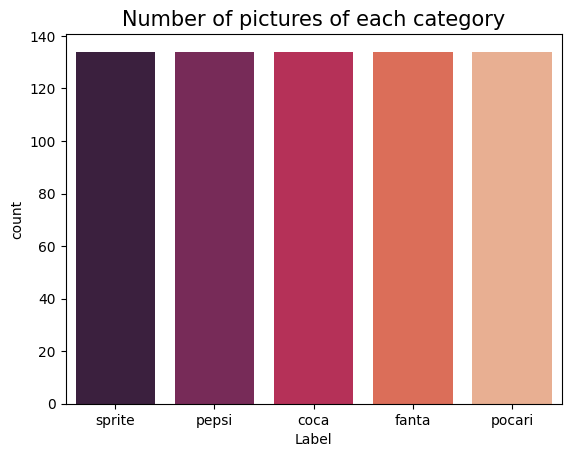

In [44]:
# Label Category 분포 확인
vc = can_df['Label'].value_counts()
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

In [45]:
# 이미지 데이터 Train, Test 데이터로 분류
train_df,test_df = train_test_split(df, test_size=0.1,random_state=0)
train_df.shape,test_df.shape

((684, 2), (77, 2))

In [46]:
import numpy as np
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split=0.2)

train_gen = train_datagen.flow_from_directory(r'C:\Users\ysm\Desktop\dataset',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',subset='training')
val_gen  = train_datagen.flow_from_directory(r'C:\Users\ysm\Desktop\dataset',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',subset='validation')

Found 610 images belonging to 5 classes.
Found 151 images belonging to 5 classes.


In [18]:
# Initialising the CNN
cnn = tf.keras.models.Sequential()

# Step 1 - Convolution
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[150, 150, 3]))

# Step 2 - Pooling
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Adding convolutional layer
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Step 3 - Flattening
cnn.add(tf.keras.layers.Flatten())

# Step 4 - Full Connection
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))

# Step 5 - Output Layer
cnn.add(tf.keras.layers.Dense(units=5, activation='softmax'))

# Compiling the CNN
cnn.compile(optimizer = 'adam', 
            loss = 'categorical_crossentropy', 
            metrics = ['accuracy'])
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 41472)             0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [19]:
cnn.fit(x = train_gen, validation_data = val_gen, epochs = 10)

Epoch 1/10


C:\Users\ysm\anaconda3\envs\cbnu\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


20/20 [==============================] - 12s 548ms/step - loss: 2.7734 - accuracy: 0.4016 - val_loss: 1.0249 - val_accuracy: 0.6159
Epoch 2/10
20/20 [==============================] - 11s 537ms/step - loss: 0.6899 - accuracy: 0.7607 - val_loss: 0.7121 - val_accuracy: 0.7616
Epoch 3/10
20/20 [==============================] - 11s 553ms/step - loss: 0.4302 - accuracy: 0.8443 - val_loss: 0.5471 - val_accuracy: 0.8079
Epoch 4/10
20/20 [==============================] - 10s 518ms/step - loss: 0.2607 - accuracy: 0.9082 - val_loss: 0.3531 - val_accuracy: 0.8609
Epoch 5/10
20/20 [==============================] - 11s 529ms/step - loss: 0.1300 - accuracy: 0.9656 - val_loss: 0.3718 - val_accuracy: 0.8675
Epoch 6/10
20/20 [==============================] - 11s 527ms/step - loss: 0.0924 - accuracy: 0.9754 - val_loss: 0.3887 - val_accuracy: 0.8742
Epoch 7/10
20/20 [==============================] - 11s 526ms/step - loss: 0.1320 - accuracy: 0.9639 - val_loss: 0.4410 - val_accuracy: 0.8278
Epoch 8/10

In [47]:
# 데이터 증강(Data Augmentation)으로 이미지 로드

def create_gen():
    # 생성기 및 데이터 증강으로 이미지 로드
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath', # 파일위치 열이름
        y_col='Label', # 클래스 열이름
        target_size=(224, 224), # 이미지 사이즈
        color_mode='rgb', # 이미지 채널수
        class_mode='categorical', # Y값(Label값)
        batch_size=32,
        shuffle=True, # 데이터를 섞을지 여부
        seed=0,
        subset='training', # train 인지 val인지 설정
        rotation_range=30, # 회전제한 각도 30도
        zoom_range=0.15, # 확대 축소 15%
        width_shift_range=0.2, # 좌우이동 20%
        height_shift_range=0.2, # 상하이동 20%
        shear_range=0.15, # 반시계방햐의 각도
        horizontal_flip=True, # 좌우 반전 True
        fill_mode="nearest"
        # 이미지 변경시 보완 방법 (constant, nearest, reflect, wrap) 4개 존재
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )
    
    return train_generator,test_generator,train_images,val_images,test_images

In [21]:
# 전이학습

models = {
    "DenseNet121": {"model":tf.keras.applications.DenseNet121, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "DenseNet201": {"model":tf.keras.applications.DenseNet201, "perf":0},
    "EfficientNetB0": {"model":tf.keras.applications.EfficientNetB0, "perf":0},
    "EfficientNetB1": {"model":tf.keras.applications.EfficientNetB1, "perf":0},
    "InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "MobileNetV3Large": {"model":tf.keras.applications.MobileNetV3Large, "perf":0},
    "ResNet152V2": {"model":tf.keras.applications.ResNet152V2, "perf":0},
    "ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0},
    "ResNet50V2": {"model":tf.keras.applications.ResNet50V2, "perf":0},
    "VGG19": {"model":tf.keras.applications.VGG19, "perf":0},
    "VGG16": {"model":tf.keras.applications.VGG16, "perf":0},
    "Xception": {"model":tf.keras.applications.Xception, "perf":0}
}
# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')

def get_model(model):
# Load the pretained model
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}
    
    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False # 레이어 동결 시켜 훈련중 손실 최소화 
    
    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(5, activation='softmax')(x)
    # 라벨 개수가 5개이므로  Dencs 5로 설정
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Train모델 학습
for name, model in models.items():
    
    # 전이 학습 모델 가져오기
    m = get_model(model['model'])
    models[name]['model'] = m
    
    start = perf_counter()
    
    # 모델 학습
    history = m.fit(train_images,validation_data=val_images,epochs=1,verbose=0)
    
    # 학습시간과 val_accuracy 저장
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")
    
    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]

Found 616 validated image filenames belonging to 5 classes.
Found 68 validated image filenames belonging to 5 classes.
Found 77 validated image filenames belonging to 5 classes.




C:\Users\ysm\anaconda3\envs\cbnu\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


DenseNet121          trained in 40.11 sec
MobileNetV2          trained in 16.07 sec
DenseNet201          trained in 62.39 sec
EfficientNetB0       trained in 24.68 sec
EfficientNetB1       trained in 34.32 sec
InceptionV3          trained in 28.04 sec
MobileNetV3Large     trained in 18.77 sec
ResNet152V2          trained in 90.76 sec
ResNet50             trained in 39.9 sec
ResNet50V2           trained in 33.74 sec
VGG19                trained in 147.44 sec
VGG16                trained in 121.33 sec
Xception             trained in 43.43 sec


In [23]:
# test데이터로 모델 성능 예측
for name, model in models.items():
    
    # Predict the label of the test_images
    pred = models[name]['model'].predict(test_images)
    pred = np.argmax(pred,axis=1)

    # Map the label
    labels = (train_images.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]

    y_test = list(test_df.Label)
    acc = accuracy_score(y_test,pred)
    models[name]['acc'] = round(acc,4)
    print(f'**{name} has a {acc * 100:.2f}% accuracy on the test set**')
   
# Create a DataFrame with the results
models_result = []

for name, v in models.items():
    models_result.append([ name, models[name]['val_acc'][-1], 
                          models[name]['acc'],
                          models[name]['perf']])
    
df_results = pd.DataFrame(models_result, 
                          columns = ['model','val_accuracy','accuracy','Training time (sec)'])
df_results.sort_values(by='accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

C:\Users\ysm\anaconda3\envs\cbnu\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3/3 [==============================] - 4s 1s/step
**DenseNet121 has a 89.61% accuracy on the test set**


C:\Users\ysm\anaconda3\envs\cbnu\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3/3 [==============================] - 1s 453ms/step
**MobileNetV2 has a 88.31% accuracy on the test set**


C:\Users\ysm\anaconda3\envs\cbnu\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3/3 [==============================] - 6s 2s/step
**DenseNet201 has a 93.51% accuracy on the test set**


C:\Users\ysm\anaconda3\envs\cbnu\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3/3 [==============================] - 2s 560ms/step
**EfficientNetB0 has a 18.18% accuracy on the test set**


C:\Users\ysm\anaconda3\envs\cbnu\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3/3 [==============================] - 3s 667ms/step
**EfficientNetB1 has a 20.78% accuracy on the test set**


C:\Users\ysm\anaconda3\envs\cbnu\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3/3 [==============================] - 2s 577ms/step
**InceptionV3 has a 63.64% accuracy on the test set**
1/3 [=========>....................] - ETA: 1s

C:\Users\ysm\anaconda3\envs\cbnu\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3/3 [==============================] - 1s 428ms/step
**MobileNetV3Large has a 51.95% accuracy on the test set**


C:\Users\ysm\anaconda3\envs\cbnu\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3/3 [==============================] - 9s 2s/step
**ResNet152V2 has a 90.91% accuracy on the test set**


C:\Users\ysm\anaconda3\envs\cbnu\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3/3 [==============================] - 4s 996ms/step
**ResNet50 has a 42.86% accuracy on the test set**


C:\Users\ysm\anaconda3\envs\cbnu\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3/3 [==============================] - 3s 812ms/step
**ResNet50V2 has a 84.42% accuracy on the test set**


C:\Users\ysm\anaconda3\envs\cbnu\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3/3 [==============================] - 11s 3s/step
**VGG19 has a 67.53% accuracy on the test set**


C:\Users\ysm\anaconda3\envs\cbnu\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3/3 [==============================] - 9s 3s/step
**VGG16 has a 54.55% accuracy on the test set**


C:\Users\ysm\anaconda3\envs\cbnu\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3/3 [==============================] - 4s 1s/step
**Xception has a 76.62% accuracy on the test set**


,model,val_accuracy,accuracy,Training time (sec)
0,DenseNet201,0.9559,0.9351,62.39
1,ResNet152V2,0.7941,0.9091,90.76
2,DenseNet121,0.8676,0.8961,40.11
3,MobileNetV2,0.8824,0.8831,16.07
4,ResNet50V2,0.7500,0.8442,33.74
5,Xception,0.6765,0.7662,43.43
6,VGG19,0.6765,0.6753,147.44
7,InceptionV3,0.5294,0.6364,28.04
8,VGG16,0.5441,0.5455,121.33
9,MobileNetV3Large,0.4706,0.5195,18.77


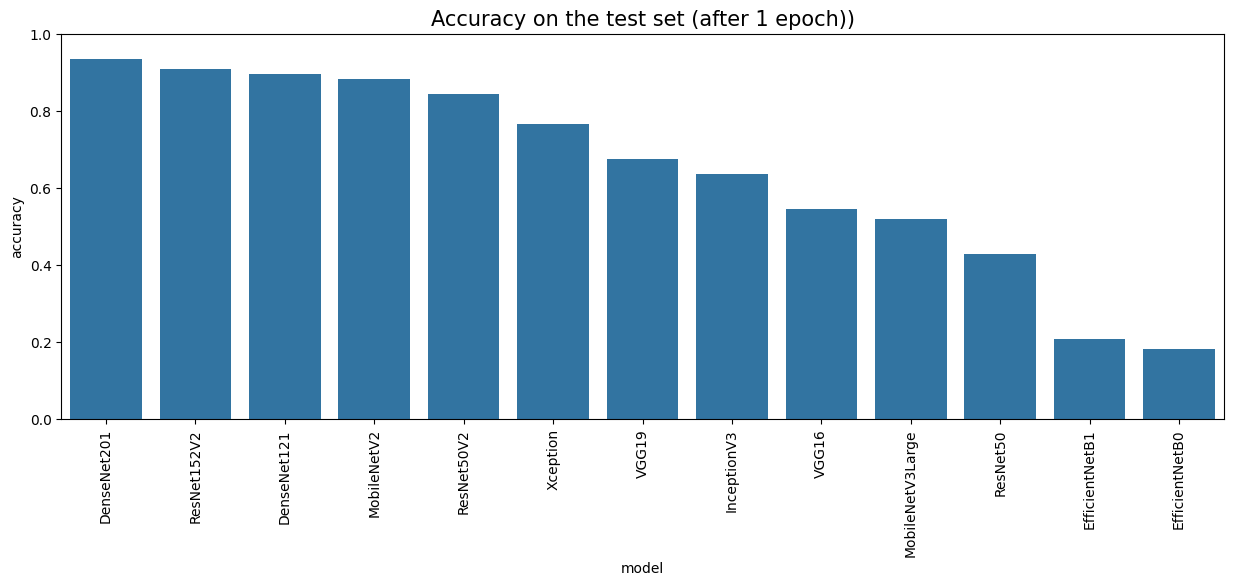

In [24]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'accuracy', data = df_results)
plt.title('Accuracy on the test set (after 1 epoch))', fontsize = 15)
plt.ylim(0,1)
plt.xticks(rotation=90)
plt.show()

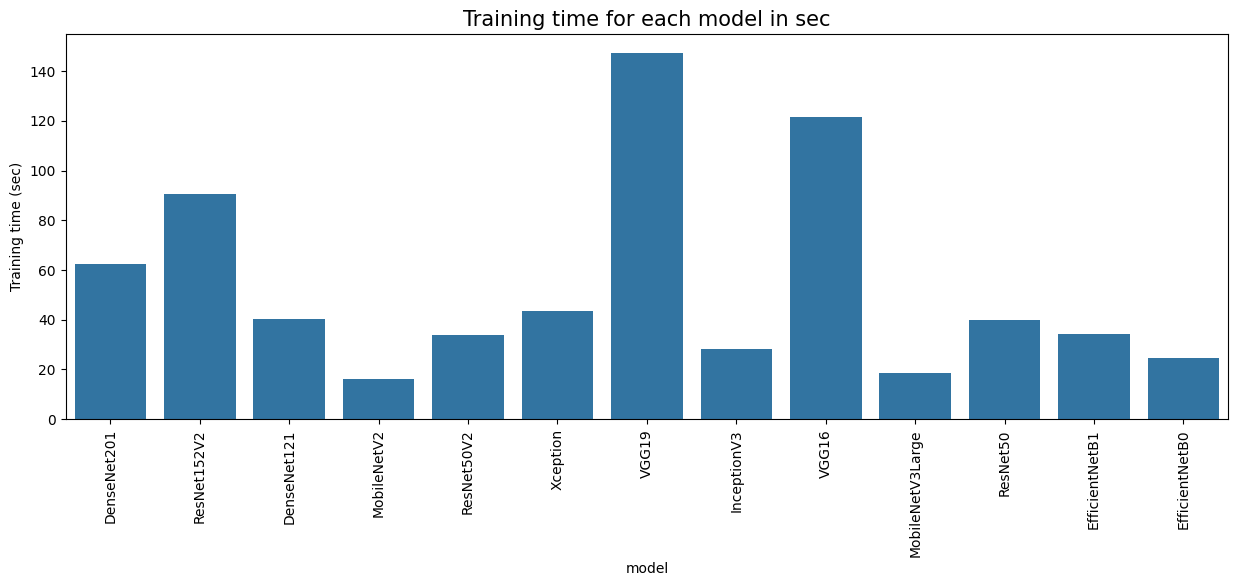

In [25]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'Training time (sec)', data = df_results)
plt.title('Training time for each model in sec', fontsize = 15)
# plt.ylim(0,20)
plt.xticks(rotation=90)
plt.show()

In [48]:
#좋은 효율을 내는 모델 성능확인 1 (DenseNet201)
train_df,test_df = train_test_split(df, test_size=0.1, random_state=0)
train_generator,test_generator,train_images,val_images,test_images=create_gen()

model = get_model(tf.keras.applications.DenseNet201)
history = model.fit(train_images,validation_data=val_images,epochs=10)

Found 616 validated image filenames belonging to 5 classes.
Found 68 validated image filenames belonging to 5 classes.
Found 77 validated image filenames belonging to 5 classes.
Epoch 1/10


C:\Users\ysm\anaconda3\envs\cbnu\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


20/20 [==============================] - 67s 3s/step - loss: 0.9853 - accuracy: 0.6688 - val_loss: 0.3371 - val_accuracy: 0.9412
Epoch 2/10
20/20 [==============================] - 55s 3s/step - loss: 0.1819 - accuracy: 0.9578 - val_loss: 0.1122 - val_accuracy: 0.9706
Epoch 3/10
20/20 [==============================] - 54s 3s/step - loss: 0.0593 - accuracy: 0.9838 - val_loss: 0.0598 - val_accuracy: 0.9706
Epoch 4/10
20/20 [==============================] - 55s 3s/step - loss: 0.0239 - accuracy: 0.9968 - val_loss: 0.0376 - val_accuracy: 1.0000
Epoch 5/10
20/20 [==============================] - 55s 3s/step - loss: 0.0103 - accuracy: 1.0000 - val_loss: 0.0261 - val_accuracy: 0.9853
Epoch 6/10
20/20 [==============================] - 55s 3s/step - loss: 0.0066 - accuracy: 1.0000 - val_loss: 0.0368 - val_accuracy: 0.9853
Epoch 7/10
20/20 [==============================] - 54s 3s/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.0232 - val_accuracy: 0.9853
Epoch 8/10
20/20 [=============

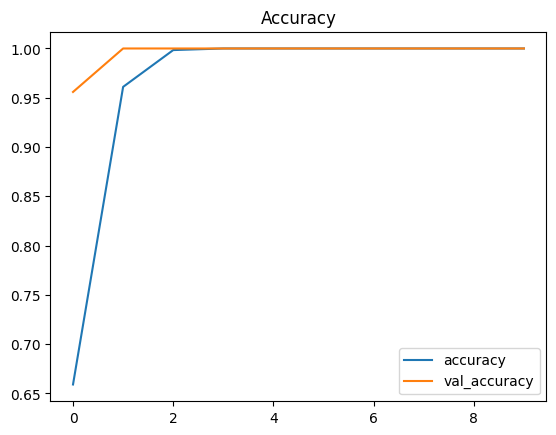

In [28]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

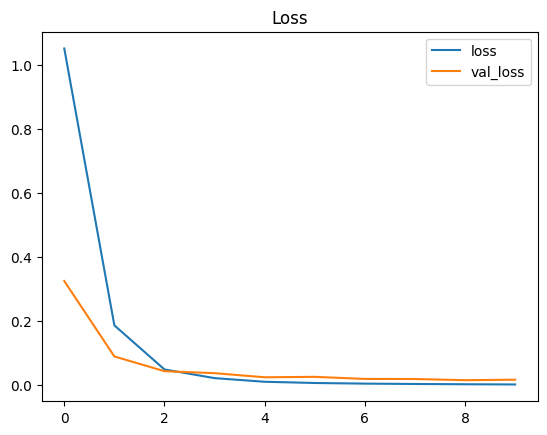

In [29]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [30]:
#좋은 효율을 내는 모델 성능확인 2 (ResNet152V2)
train_df,test_df = train_test_split(df, test_size=0.1, random_state=0)
train_generator,test_generator,train_images,val_images,test_images=create_gen()

model = get_model(tf.keras.applications.ResNet152V2)
history = model.fit(train_images,validation_data=val_images,epochs=10)

Found 616 validated image filenames belonging to 5 classes.
Found 68 validated image filenames belonging to 5 classes.
Found 77 validated image filenames belonging to 5 classes.
Epoch 1/10


C:\Users\ysm\anaconda3\envs\cbnu\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


20/20 [==============================] - 88s 4s/step - loss: 0.9866 - accuracy: 0.6153 - val_loss: 0.6927 - val_accuracy: 0.7206
Epoch 2/10
20/20 [==============================] - 78s 4s/step - loss: 0.3053 - accuracy: 0.8994 - val_loss: 0.4299 - val_accuracy: 0.8676
Epoch 3/10
20/20 [==============================] - 79s 4s/step - loss: 0.1499 - accuracy: 0.9562 - val_loss: 0.5182 - val_accuracy: 0.8382
Epoch 4/10
20/20 [==============================] - 86s 4s/step - loss: 0.0827 - accuracy: 0.9838 - val_loss: 0.3931 - val_accuracy: 0.8971
Epoch 5/10
20/20 [==============================] - 85s 4s/step - loss: 0.0399 - accuracy: 0.9968 - val_loss: 0.4469 - val_accuracy: 0.8824
Epoch 6/10
20/20 [==============================] - 82s 4s/step - loss: 0.0272 - accuracy: 0.9968 - val_loss: 0.4486 - val_accuracy: 0.8971
Epoch 7/10
20/20 [==============================] - 84s 4s/step - loss: 0.0133 - accuracy: 1.0000 - val_loss: 0.4901 - val_accuracy: 0.8971
Epoch 8/10
20/20 [=============

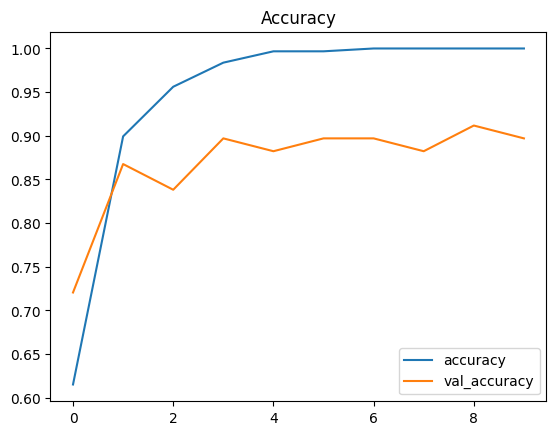

In [31]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

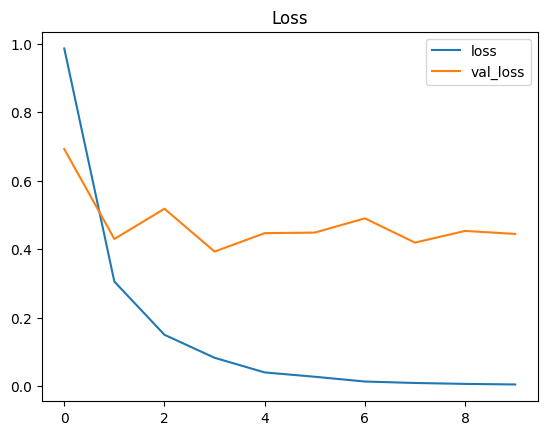

In [32]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [33]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

def printmd(string):
    # Print with Markdowns    
    display(Markdown(string))
    
y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
printmd(f'# Accuracy on the test set: {acc * 100:.2f}%')

C:\Users\ysm\anaconda3\envs\cbnu\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3/3 [==============================] - 11s 2s/step


# Accuracy on the test set: 93.51%

In [34]:
#모델의 정밀도와 재현율
class_report = classification_report(y_test, pred, zero_division=1)
print(class_report)

              precision    recall  f1-score   support

        coca       1.00      0.92      0.96        13
       fanta       0.93      0.87      0.90        15
       pepsi       0.90      1.00      0.95        19
      pocari       0.93      1.00      0.97        14
      sprite       0.93      0.88      0.90        16

    accuracy                           0.94        77
   macro avg       0.94      0.93      0.94        77
weighted avg       0.94      0.94      0.93        77



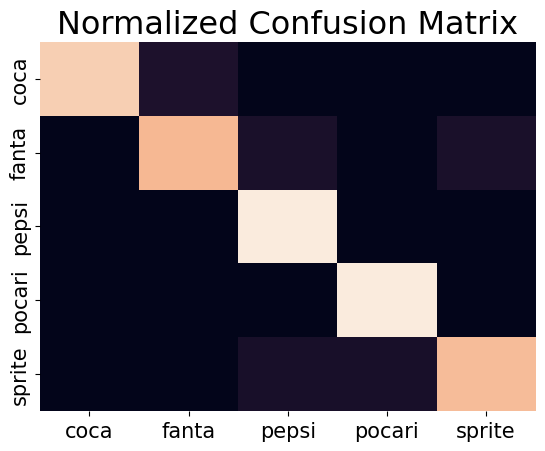

In [35]:
#Confusion Matrix 시각화
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
sns.heatmap(cf_matrix, annot=False, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)),cbar=False)
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

1/1 [==============================] - 3s 3s/step


## 예측률 : 97.78%

### Class prediction = coca

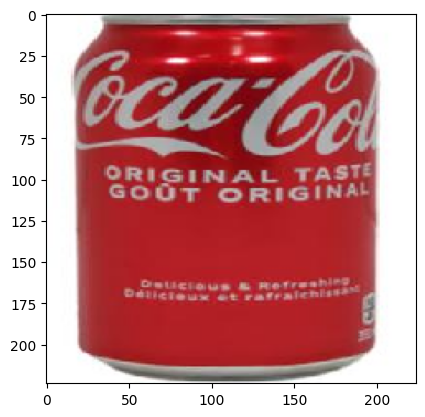

In [36]:
# 모델 예측
# from PIL import Image
import pandas as pd
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
def printmd(string):
    # Print with Markdowns    
    display(Markdown(string))
class_dictionary = {'coca': 0,
                    'fanta': 1,
                    'pepsi': 2,
                    'pocari': 3,
                    'sprite': 4}
IMAGE_SIZE    = (224, 224)

#테스트할 이미지
image_path = r"C:\Users\ysm\Desktop\dataset\coca\coca173.jpg"
test_image = image.load_img(image_path, target_size =IMAGE_SIZE )
test_image = image.img_to_array(test_image)
plt.imshow(test_image/255.);

test_image = test_image.reshape((1, test_image.shape[0], test_image.shape[1], test_image.shape[2]))
test_image = preprocess_input(test_image)
prediction = model.predict(test_image)

df = pd.DataFrame({'pred':prediction[0]})
df = df.sort_values(by='pred', ascending=False, na_position='first')
printmd(f"## 예측률 : {(df.iloc[0]['pred'])* 100:.2f}%")

for x in class_dictionary:
  if class_dictionary[x] == (df[df == df.iloc[0]].index[0]):
    printmd(f"### Class prediction = {x}")
    break

In [37]:
##실제 데이터 테스트##

#데이터 경로
base_dir = Path(r'C:\Users\ysm\Desktop\testdata')
brands = ['coca', 'fanta', 'pepsi', 'pocari', 'sprite']  # 브랜드 목록

# 각 브랜드별 이미지 파일 경로 수집
filepaths = []
labels = []

for brand in brands:
    brand_dir = base_dir / brand  # 각 브랜드의 폴더 경로
    brand_images = list(brand_dir.glob(r'*.jpg'))  # JPG 이미지만 수집
    filepaths.extend(brand_images)
    labels.extend([brand] * len(brand_images))  # 브랜드 이름으로 라벨 지정

# 데이터프레임 생성
df = pd.DataFrame({
    'Filepath': [str(fp) for fp in filepaths],
    'Label': labels
})

# 음료수 별 이미지 수 최소값 찾기 
min_count = df['Label'].value_counts().min()

# 그 수를 기준으로 샘플링
can_df = pd.concat([
    df[df['Label'] == brand].sample(min_count, random_state=0)
    for brand in brands
])
can_df = can_df.sample(frac=1, random_state=0).reset_index(drop=True)

# 라벨링 확인
print(can_df)

                                            Filepath   Label
0  C:\Users\ysm\Desktop\testdata\fanta\test2.fant...   fanta
1  C:\Users\ysm\Desktop\testdata\sprite\test2.spr...  sprite
2  C:\Users\ysm\Desktop\testdata\pepsi\test2.peps...   pepsi
3  C:\Users\ysm\Desktop\testdata\sprite\test1.spr...  sprite
4  C:\Users\ysm\Desktop\testdata\coca\test1.coca.jpg    coca
5  C:\Users\ysm\Desktop\testdata\pocari\test2.poc...  pocari
6  C:\Users\ysm\Desktop\testdata\pocari\tes1.poca...  pocari
7  C:\Users\ysm\Desktop\testdata\fanta\test1.fant...   fanta
8  C:\Users\ysm\Desktop\testdata\coca\test2.coca.jpg    coca
9  C:\Users\ysm\Desktop\testdata\pepsi\test1.peps...   pepsi


1/1 [==============================] - 0s 226ms/step


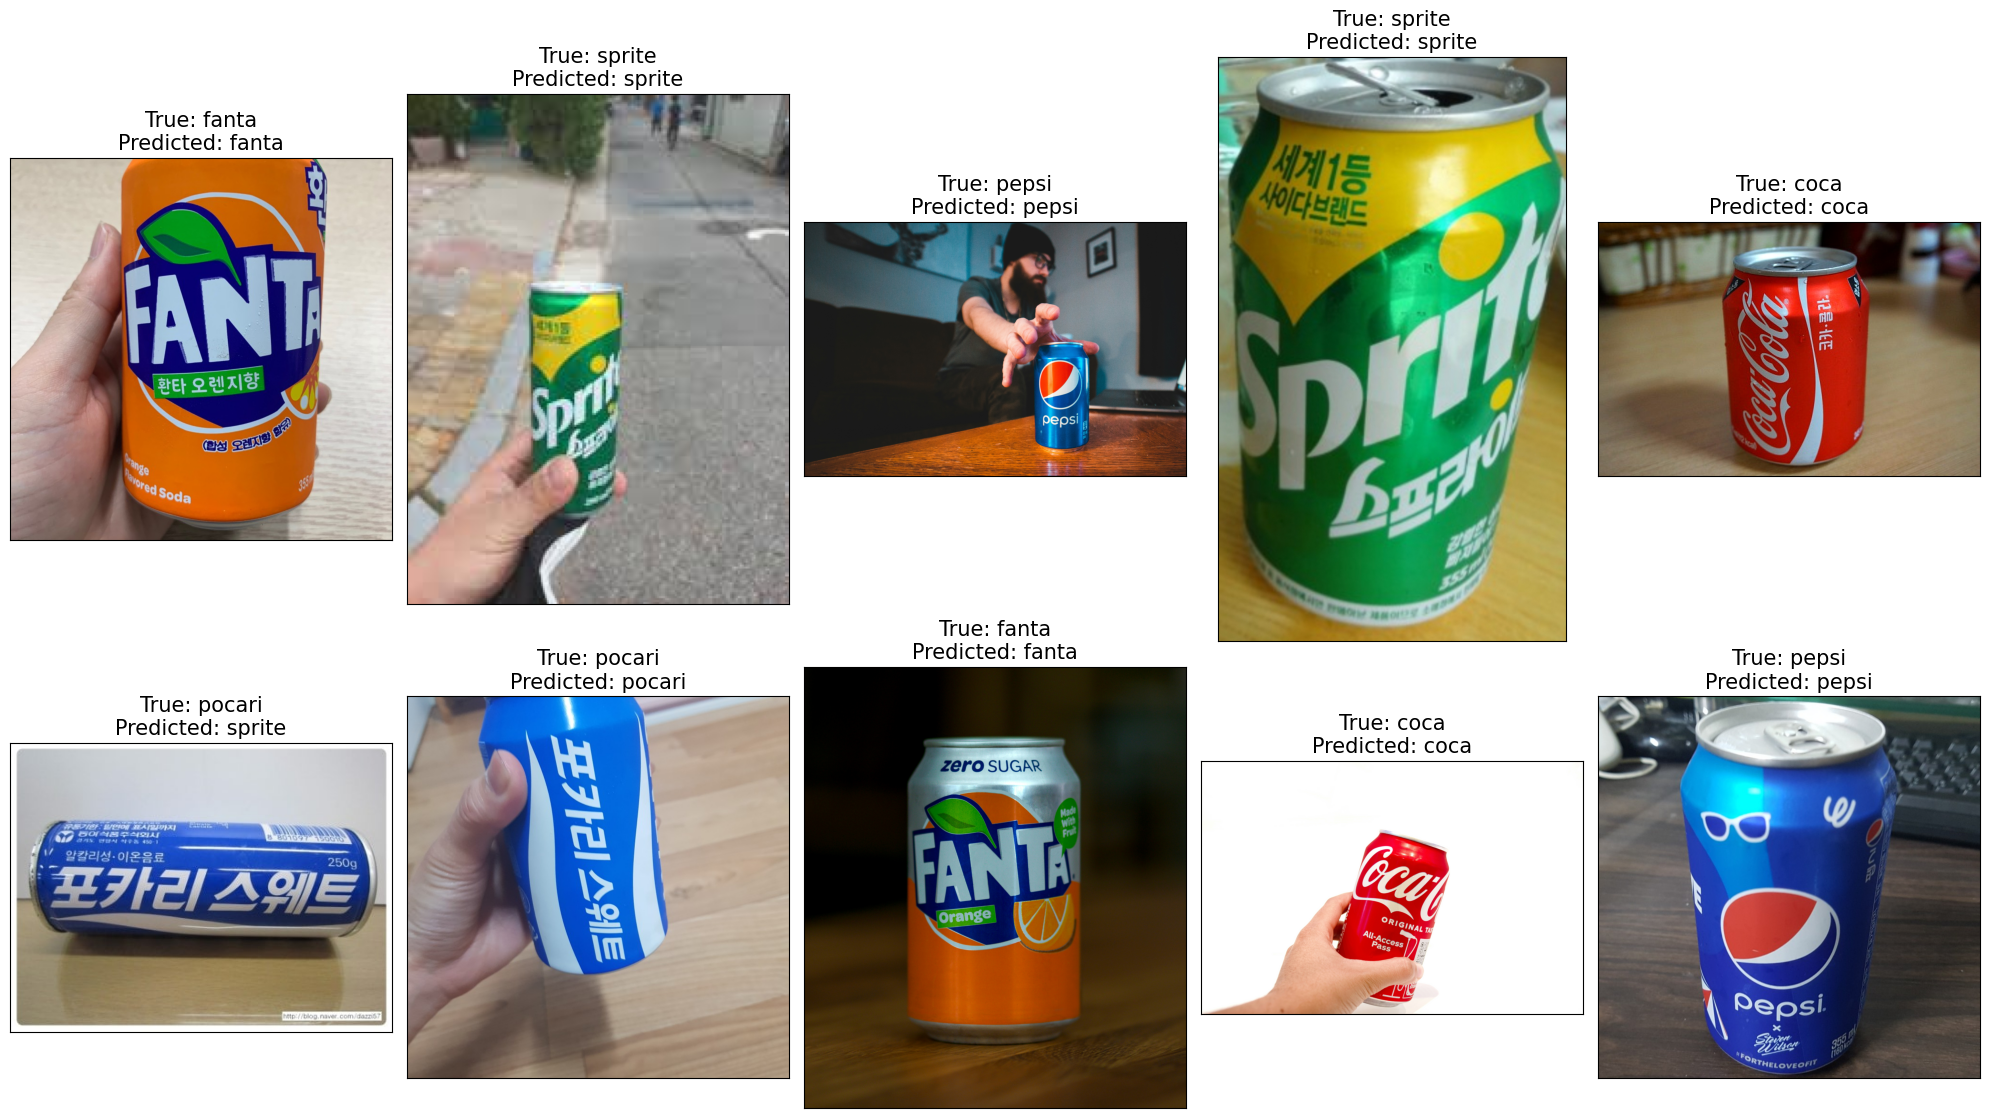

In [39]:
# 여러 이미지 예측 및 시각화
IMAGE_SIZE = (224, 224)
predictions = []

# 이미지 전처리 및 예측
for filepath in can_df['Filepath']:
    img = image.load_img(filepath, target_size=IMAGE_SIZE)
    img_array = image.img_to_array(img)
    img_array = img_array.reshape((1, img_array.shape[0], img_array.shape[1], img_array.shape[2]))
    img_array = preprocess_input(img_array)
    
    pred = model.predict(img_array)
    pred_class = np.argmax(pred, axis=1)
    
    predictions.append(pred_class[0])

# 클래스 인덱스 매핑
class_labels = {v: k for k, v in class_dictionary.items()}
can_df['Predicted'] = [class_labels[pred] for pred in predictions]

# 시각화
fig, axes = plt.subplots(nrows=, ncols=5, figsize=(20, 12),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    if i < len(can_df):
        img = plt.imread(can_df.Filepath.iloc[i])
        ax.imshow(img)
        true_label = can_df.Label.iloc[i]
        predicted_label = can_df.Predicted.iloc[i]
        ax.set_title(f"True: {true_label}\nPredicted: {predicted_label}", fontsize=15)
plt.tight_layout()
plt.show()